In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

In [2]:
#img1 is the base image on which the other one will be added
def SiftImplementation(img1, img2, keypoints_1, keypoints_2, descriptors_1, descriptors_2):
    #matches between img1, img2
    match = cv2.BFMatcher()
    matches = match.knnMatch(descriptors_1, descriptors_2, k=2)

    good = []
    for m,n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
            
    src_pts = np.float32([ keypoints_1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints_2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    #parameters for the drawMatches() function    
    draw_params = dict(singlePointColor = None,
                        flags = 2)

    SiftImage = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, good, None, **draw_params)
    """plt.imshow(SiftImage)
    plt.title("Matches after the implementation of SIFT detector")
    plt.show()"""
    
    #HOMOGRAPHY - RANSAC
    M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    draw_params4 = dict(singlePointColor = None,
                                    matchesMask = matchesMask, # draw only good inliers points
                                    flags = 2)

    img4  = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, good, None, **draw_params4)
    plt.imshow(img4)
    plt.title("Matches after Ransac's algorithm implementation")
    plt.show() 
    
    return(M)  

In [3]:
def ImageStitching(M, img1, img2):
    #z contains some details about the colour of the image
    h, w, z = img2.shape
    InitialMatrix = np.array([[0, w -1, w -1,0],[0,0, h -1, h-1],[1,1,1,1]])

    # Finding the final coordinates (xi, yi) of the cornersof the
    # # image after transformation.
    FinalMatrix = np.dot(M, InitialMatrix)
    [x, y, c] = FinalMatrix
    x = np.divide(x, c)
    y = np.divide(y, c)

    min_x, max_x =int(round(min(x))),int(round(max(x)))
    min_y, max_y =int(round(min(y))),int(round(max(y)))

    New_Width = max_x
    New_Height = max_y
    Correction = [0,0]

    if min_x <0:
        New_Width -= min_x
        Correction[0] =abs(min_x)
    if min_y <0: 
        New_Height -= min_y
        Correction[1] =abs(min_y)
        
        
    if New_Width < (img1.shape[1] + Correction[0]):
        New_Width = img1.shape[1] + Correction[0]
    if New_Height < (img1.shape[0] + Correction[1]):
        New_Height = img1.shape[0] + Correction[1]
        
        
    x = np.add(x, Correction[0])
    y = np.add(y, Correction[1])

    OldInitialPoints = np.float32([[0,0],[w -1,0],[w -1, h-1],[0, h -1]])
    NewFinalPonts = np.float32(np.array([x, y]).transpose())

    HomographyMatrix = cv2.getPerspectiveTransform(OldInitialPoints,NewFinalPonts)
     
    
    return [New_Height, New_Width], Correction, HomographyMatrix

In [4]:
#find the directory we are inside
directoryName =  os.path.dirname(os.path.realpath('__file__'))

In [5]:
#add all the images in a list
filenames = []
for filename in os.listdir(directoryName):
    filenames.append(filename)

In [6]:
filenames.sort()  

In [7]:
images = []
for filename in filenames:
    img = cv2.imread(os.path.join(directoryName,filename))
    if img is not None:
        images.append(img)

In [8]:
if(len(images) <= 1):
    print("Small number of images")
    exit()

In [9]:
img1 = images[0]
img2 = images[1]

In [10]:
#SIFT
sift = cv2.SIFT_create()

In [11]:
#img2 will be the base
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

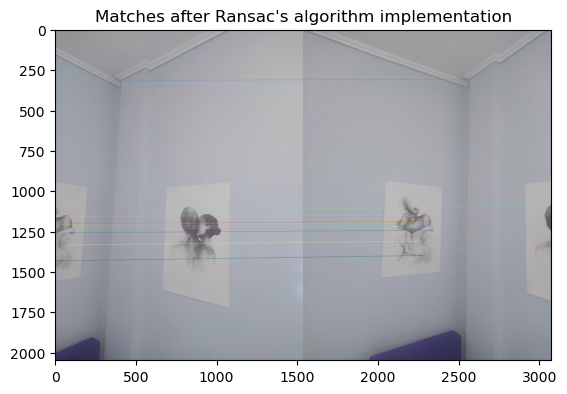

In [12]:
M = SiftImplementation(img2, img1, keypoints_2, keypoints_1, descriptors_2, descriptors_1)

In [13]:
[New_Height, New_Width], Correction, HomographyMatrix = ImageStitching(M, img2, img1)

In [14]:
StitchedImage = cv2.warpPerspective(img1, HomographyMatrix,(New_Height, New_Width))

In [15]:
StitchedImage[Correction[1]:Correction[1]+img2.shape[0],Correction[0]:Correction[0]+img2.shape[1]]= img2

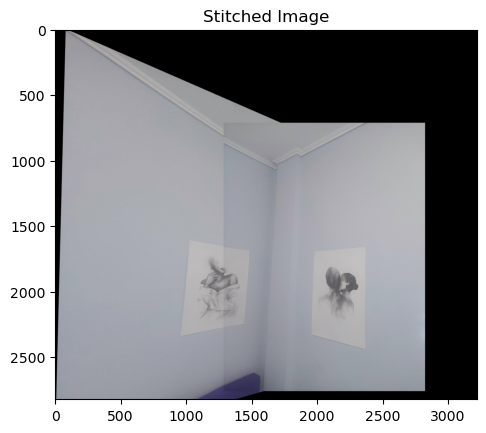

In [16]:
plt.imshow(StitchedImage)
plt.title("Stitched Image")
plt.show()

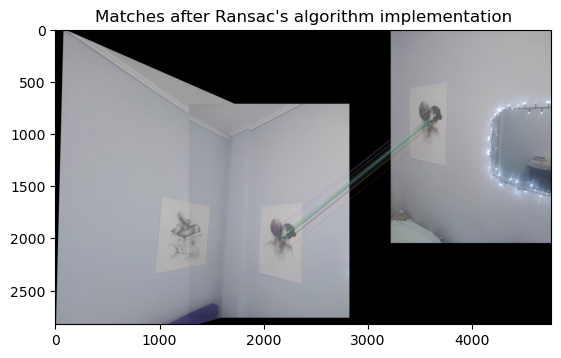

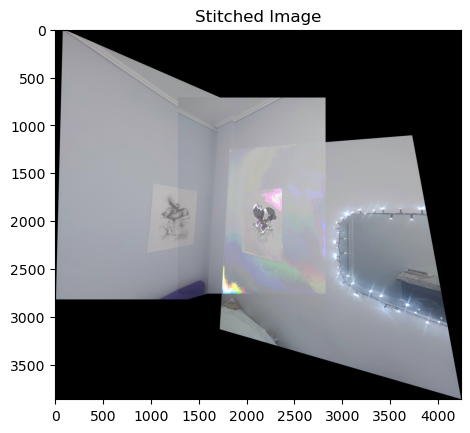

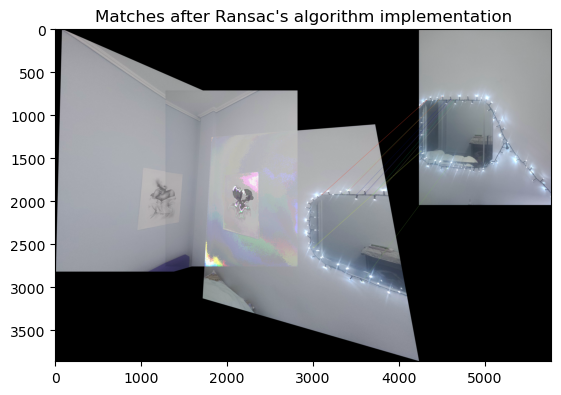

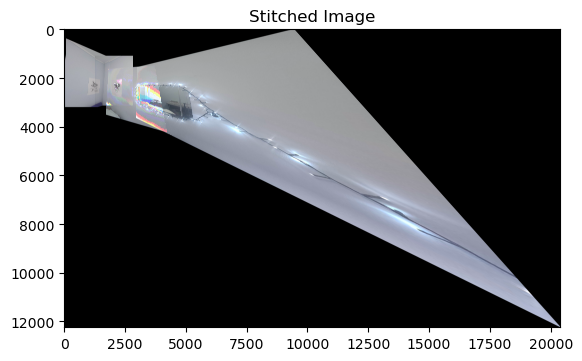

In [17]:
for i in range(2, len(images)):
    img3 = images[i]

    Sift = cv2.SIFT_create()

    keypoints_4, descriptors_4 = Sift.detectAndCompute(cv2.cvtColor(StitchedImage, cv2.COLOR_BGR2GRAY), None)
    keypoints_3, descriptors_3 = sift.detectAndCompute(cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY), None)

    SecImage_Mask = np.zeros(img3.shape, dtype=np.uint8)

    M = SiftImplementation(StitchedImage, img3, keypoints_4, keypoints_3, descriptors_4, descriptors_3)

    [New_Height, New_Width], Correction, M = ImageStitching(M, StitchedImage, img3)

    # Finally placing the images upon one another.
    SecImage_Transformed = cv2.warpPerspective(img3, M, (New_Width, New_Height))
    SecImage_Transformed_Mask = cv2.warpPerspective(SecImage_Mask, M, (New_Width, New_Height))
    BaseImage_Transformed = np.zeros((New_Height, New_Width, 3), dtype=np.uint8)
    BaseImage_Transformed[Correction[1]:Correction[1]+StitchedImage.shape[0], Correction[0]:Correction[0]+StitchedImage.shape[1]] = StitchedImage

    StitchedImage = cv2.bitwise_or(SecImage_Transformed, cv2.bitwise_and(BaseImage_Transformed, cv2.bitwise_not(SecImage_Transformed_Mask)))

    plt.imshow(StitchedImage)
    plt.title("Stitched Image")
    plt.show()